In [1]:
import trenchripper as tr

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
import warnings
import random
import statsmodels.api as sm

from matplotlib import pyplot as plt

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

random.seed(42)
np.random.seed(42)

dask_wd = "/home/de64/scratch/de64/dask"

warnings.filterwarnings(action='once',category=UserWarning)

plt.style.use('./deaton.mplstyle')

### Load Functions

In [2]:
def compute_volume(length,width): ##spherocylinder
    volume = np.pi * ((1/4)*(width**2)*(length-width) + (1/6)*(width**3))
    return volume

# def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
#     namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
#     print("Searching for " + str(obodag[go_term].name))
#     namespace = namespace_abbv[obodag[go_term].namespace]
#     child_goterms = list(obodag[go_term].get_all_children())
#     gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
#     for child_goterm in child_goterms:    
#         gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
#     gene_list = sorted(list(set(gene_list)))
#     return gene_list

def get_std(plate_data,plate_map,plate_map_std_dict):
    standard_vals = []
    standard_signal = []
    for key,val in plate_map_std_dict.items():
        selected_data = np.array(plate_data[plate_map==key]).flatten()
        selected_data = selected_data[~np.isnan(selected_data)]
        working_standard_vals = [val for i in range(len(selected_data))]
        standard_vals += working_standard_vals
        standard_signal += list(selected_data)
    standard_vals = np.array(standard_vals)
    standard_signal = np.array(standard_signal)
    return standard_vals,standard_signal

def linear_regression(plate_data,plate_map,plate_map_std_dict):
    ##extract standard values
    std_vals,std_signal = get_std(plate_data,plate_map,plate_map_std_dict)
    
    ##linear regression
    reg = skl.linear_model.LinearRegression().fit(std_vals.reshape(-1,1),std_signal)
    predict = reg.predict(std_vals.reshape(-1,1))
    resid = (std_signal - predict)
    reg_uncertainty = np.sqrt(np.sum(resid**2)/(len(resid)-2))
    slope_uncertainty = reg_uncertainty/np.sqrt(np.sum((std_vals-np.mean(std_vals))**2))

    ## calculating LOQ by standard error of regression slope
    deriv = reg.coef_[0]    
    intercept = reg.intercept_
    loq = 10*(slope_uncertainty/deriv)
    print("LOQ: " + str(loq))
    
    predicted_concentrations = plate_data.apply(lambda x: (x-intercept)/deriv)
    samples_mask = ~plate_map.isin(list(plate_map_std_dict.keys()) + [np.NaN])
    all_samples_list = plate_map.values[samples_mask.values]
    all_sample_vals_list = predicted_concentrations.values[samples_mask.values]
    return all_samples_list,all_sample_vals_list

### Load Data

In [3]:
ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

ss_isolate_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/Mother_Machine_Imaging/2024-11-01_Steady_State_df_Estimators_wStats.pkl")
ss_isolate_estimators_df = ss_isolate_estimators_df.loc["Mean (Robust)"]

In [4]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Width','Instantaneous Growth Rate: Volume']
prolif_params = []
param_names = [r"Length ($ \mu m $)",r"Width ($ \mu m $)",r"Volume ($ \mu m^{3} $)"]
param_ranges = [(0.,10.),(1.3,1.6),(0.,2.2)]
param_ticks = [[0,2,4,6,8,10],[1.3,1.4,1.5,1.6],[0.,1.,2.]]

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
sem_ratio_thr_ss = 0.2

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<sem_ratio_thr_ss]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

##import isolates

final_columns = ["Condition","Category"]
control_categories = ["Control"]

final_isolate_column_df = ss_isolate_estimators_df.reset_index().groupby("Condition Index").first()[final_columns]
ss_isolate_estimators_df["SEM/Location"] = (np.sqrt(ss_isolate_estimators_df["Estimator Variance"])/ss_isolate_estimators_df["Value"]).copy()
ss_isolate_estimators_df = ss_isolate_estimators_df[ss_isolate_estimators_df["SEM/Location"]<sem_ratio_thr_ss]
ss_isolate_estimators_df = ss_isolate_estimators_df.reset_index().set_index(["Condition Index"])

##hack to get both observatoins and proliferating observations (was broken)
isolate_observation_df = ss_isolate_estimators_df[ss_isolate_estimators_df["Variable(s)"] == "Length"][["N Observations"]]

isolate_variance_estimators_df = ss_isolate_estimators_df[["Variable(s)","Estimator Variance"]]
ss_isolate_estimators_df = ss_isolate_estimators_df[["Variable(s)","Value"]]
ss_isolate_estimators_df = ss_isolate_estimators_df.pivot(columns=["Variable(s)"])
isolate_variance_estimators_df = isolate_variance_estimators_df.pivot(columns=["Variable(s)"])

ss_isolate_estimators_df.columns = ss_isolate_estimators_df.columns.droplevel(0)
isolate_variance_estimators_df.columns = isolate_variance_estimators_df.columns.droplevel(0)
isolate_variance_estimators_df.columns = [column + " SEM" for column in isolate_variance_estimators_df.columns]
isolate_variance_estimators_df = np.sqrt(isolate_variance_estimators_df)
ss_isolate_estimators_df = ss_isolate_estimators_df.join(isolate_observation_df,on=['Condition Index'])
ss_isolate_estimators_df = ss_isolate_estimators_df.join(isolate_variance_estimators_df,on=['Condition Index'])

ss_isolate_estimators_df = ss_isolate_estimators_df[ss_isolate_estimators_df["N Observations"]>=min_n_observations]
ss_isolate_estimators_df["Instantaneous Growth Rate: Volume"] = ss_isolate_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_isolate_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_isolate_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_isolate_estimators_df = ss_isolate_estimators_df.join(final_isolate_column_df)
ss_isolate_estimators_df = ss_isolate_estimators_df.dropna(subset=params_of_interest)

### Adding Volumes
- Skipping errors for now

In [5]:
ss_estimators_df["Volume"] = compute_volume(ss_estimators_df["Length"],ss_estimators_df["Width"])
ss_isolate_estimators_df["Volume"] = compute_volume(ss_isolate_estimators_df["Length"],ss_isolate_estimators_df["Width"])

# ##removing controls
control_categories = ['OnlyPlasmid', 'NoTarget']
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
control_categories = ["Control"]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

In [6]:
infA_sgrnaid = 20899
pheT_sgrnaid = 23961
wt_sgrnaid = 29672

# Define a custom palette, style consistent with rest of figure
strain_pallette = {'WT':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'EV':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'tufA':(1.0, 0.4980392156862745, 0.054901960784313725), \
                   'rplL':(0.7901960784313726, 0.7019607843137254, 0.8705882352941177), \
                   'infA':(0.8874509803921569, 0.40705882352941175, 0.40980392156862744), \
                   'pheT':(1.0, 0.4980392156862745, 0.054901960784313725), \
                   'fusA':(0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                   r'$p_{AHL}$-fusA': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                   'fusA*':(0.5803921568627451, 0.403921568627451, 0.7411764705882353)}

## infA
infA_df = ss_estimators_df[ss_estimators_df["Gene"]=="infA"]
## pheT
pheT_df = ss_estimators_df[ss_estimators_df["Gene"]=="pheT"]
## rplL
rplL_df = ss_estimators_df[ss_estimators_df["Gene"]=="rplL"]
## hisS
hisS_df = ss_estimators_df[ss_estimators_df["Gene"]=="hisS"]
## controls
wt_df = ss_estimators_df_controls_only.loc[[wt_sgrnaid]]

## isolates
non_fusA_isolate_df = ss_isolate_estimators_df.loc[[9,10,11,12]]
non_fusA_isolate_df["Color"] = non_fusA_isolate_df["Condition"].apply(lambda x: strain_pallette[x])

all_fusA_isolate_df = ss_isolate_estimators_df.loc[[0,1,2,3,4,5,6,7,8]]
all_fusA_isolate_df["Color"] = [(0.5803921568627451, 0.403921568627451, 0.7411764705882353) for i in range(9)]
all_fusA_isolate_df["Gene"] = "fusA"

fusA_isolate_df = ss_isolate_estimators_df.loc[[1,2,3,4,5,6,7,8]]
fusA_isolate_df["Color"] = [(0.5803921568627451, 0.403921568627451, 0.7411764705882353) for i in range(8)]
fusA_isolate_df["Gene"] = "fusA"

uninduced_fusA_isolate_df = ss_isolate_estimators_df.loc[[0]]
uninduced_fusA_isolate_df["Color"] = [(0.5803921568627451, 0.403921568627451, 0.7411764705882353) for i in range(1)]
uninduced_fusA_isolate_df["Gene"] = "fusA"

pheT_df["Ribo Type"] = "tRNA Synthetase"
hisS_df["Ribo Type"] = "tRNA Synthetase"
all_fusA_isolate_df["Ribo Type"] = "Ribosome"

infA_growth_volume_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="infA"]
pheT_growth_volume_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="pheT"]
rplL_growth_volume_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="rplL"]
EV_growth_volume_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="EV"]

/tmp/ipykernel_503/4233733287.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheT_df["Ribo Type"] = "tRNA Synthetase"
/tmp/ipykernel_503/4233733287.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hisS_df["Ribo Type"] = "tRNA Synthetase"


### Loading RNA/Protein Samples

In [7]:
def get_sample_idx(sample_name_list):
    sample_idx = []
    for sample_name in sample_name_list:
        strain,replicate = sample_name.split("\n")
        replicate = int(replicate[1:])
        sample_idx.append((strain,replicate))
    return sample_idx

Protein_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_1.xlsx",skiprows=0,index_col=0,usecols=range(0,13))
Protein_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_2.xlsx",skiprows=0,index_col=0,usecols=range(0,13))
Protein_data_1 = pd.concat([Protein_data_plate_1,Protein_data_plate_2]).reset_index(drop=True)

RNA_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_1.xlsx",skiprows=0,index_col=0,usecols=range(0,13))
RNA_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_2.xlsx",skiprows=0,index_col=0,usecols=range(0,13))
RNA_data_1 = pd.concat([RNA_data_plate_1,RNA_data_plate_2]).reset_index(drop=True)

Protein_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_Map_1.xlsx",skipfooter=11,index_col=0,usecols=range(2))['Concentrations (ug/mL)'].to_dict()
RNA_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_Map_1.xlsx",skipfooter=9,index_col=0,usecols=range(2))['Concentrations (ng/ul)'].to_dict()

Protein_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/Protein_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_merged_1 = pd.concat([Protein_plate_map_1,Protein_plate_map_2]).reset_index(drop=True)
Protein_plate_map_merged_1.columns = Protein_plate_map_merged_1.columns.astype(int)

RNA_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein_Set_2/RNA_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_merged_1 = pd.concat([RNA_plate_map_1,RNA_plate_map_2]).reset_index(drop=True)
RNA_plate_map_merged_1.columns = RNA_plate_map_merged_1.columns.astype(int)

protein_samples_list_1,protein_sample_vals_list_1 = linear_regression(Protein_data_1,Protein_plate_map_merged_1,Protein_plate_map_standard_dict)
RNA_samples_list_1,RNA_sample_vals_list_1 = linear_regression(RNA_data_1,RNA_plate_map_merged_1,RNA_plate_map_standard_dict)

protein_samples_idx_1 = get_sample_idx(protein_samples_list_1)
Protein_output_df_1 = pd.DataFrame(protein_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","Replicate"]))

RNA_output_df_1 = (pd.DataFrame(RNA_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","Replicate"]))/2)*20
RNA_prot_ratio_df_1 = (RNA_output_df_1/Protein_output_df_1).sort_index()

RNA_prot_ratio_df_1 = RNA_prot_ratio_df_1.reset_index().set_index(["Strain","Replicate"])

RNA_prot_ratio_df = pd.concat([RNA_prot_ratio_df_1]).sort_index()
RNA_prot_ratio_df_translation = RNA_prot_ratio_df.reset_index()
# RNA_prot_ratio_df_translation["Strain"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: int(x[2:]))
strain_name_map = {'DE787':('WT',29672), 'DE806-0.00':(r'$p_{AHL}$-fusA',0), 'DE806-0.13':(r'$p_{AHL}$-fusA',7), 'DE806-0.20':(r'$p_{AHL}$-fusA',5),
                   'DE806-1.00':(r'$p_{AHL}$-fusA',4), 'DE814':('rplL',702), 'DE816':('infA',20899),'DE817':('pheT',23961),
                   'DE847':('rplL',694), 'DE848':('rplL',706), 'DE849':('rplL',711),'DE850':('infA',4925),
                   'DE851':('infA',4926), 'DE852':('pheT',9220), 'DE853':('infA',20903),'DE854':('pheT',23953),
                  'DE855':('pheT',23957)}

RNA_prot_ratio_df_translation["Strain Name"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: strain_name_map[x][0])
RNA_prot_ratio_df_translation["sgRNAid/Condition"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: strain_name_map[x][1])
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.drop(columns=["Strain"], axis=0)
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.set_index(["Strain Name","sgRNAid/Condition","Replicate"])
RNA_prot_ratio_df_translation.columns = ['RNA/Protein']

LOQ: 0.10138132764820595
LOQ: 0.2533060949322871


In [8]:
# # Get ontologies
# obo_fname = download_go_basic_obo()

# # Get ecoli association file (ecocyc)

# gaf_handle = goatools.base.http_get("http://release.geneontology.org/2024-11-03/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
# gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

# ## Getting ontologies and other nonesense

# obodag = GODag(obo_fname)
# objanno = GafReader(gaf_fname)
# ns2assoc = objanno.get_ns2assc()

# gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
# inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
# synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
# gene_to_id.update(synonym_dict)

In [9]:
ribo_stalk = ["rplJ","rplL"]

ribo = ['rplA', 'rplB', 'rplC', 'rplD', 'rplE', 'rplF', 'rplI',\
 'rplJ', 'rplK', 'rplL', 'rplM', 'rplN', 'rplO', 'rplP', \
 'rplQ', 'rplR', 'rplS', 'rplT', 'rplU', 'rplV', 'rplW', \
 'rplX', 'rplY', 'rpmA', 'rpmB', 'rpmC', 'rpmD', 'rpmE', \
 'rpmF', 'rpmG', 'rpmH', 'rpmI', 'rpmJ', 'rpsA', 'rpsB', \
 'rpsC', 'rpsD', 'rpsE', 'rpsF', 'rpsG', 'rpsH', 'rpsI', \
 'rpsJ', 'rpsK', 'rpsL', 'rpsM', 'rpsN', 'rpsO', 'rpsP', \
 'rpsQ', 'rpsR', 'rpsS', 'rpsT', 'rpsU', 'ykgM', 'ykgO']

trna_synthetases = ['alaS', 'argS', 'asnS', 'aspS', 'cysS', \
'glnS', 'gltX', 'glyQ', 'glyS', 'hisS', 'ileS', 'leuS', \
'lysS', 'lysU', 'metG', 'pheS', 'pheT', 'proS', 'serS', \
'thrS', 'trpS',  'tyrS', 'valS']

initation_factors = ["infA","infB"]

all_ribo = ribo + trna_synthetases + initation_factors

ribo_relabel = {**{item: "Ribosome" for item in list(set(ribo)-set(ribo_stalk))},\
 **{item: "tRNA Synthetase" for item in trna_synthetases},**{item: "Ribosome Stalk" for item in ribo_stalk},\
               **{item: "Initiation Factor" for item in initation_factors}}

ribo_df = ss_estimators_df[ss_estimators_df["Gene"].isin(ribo)].copy()
ribo_df["Gene"] = ribo_df["Gene"].astype(str)
ribo_df["Ribo Type"] = ribo_df["Gene"].apply(lambda x: ribo_relabel[x])

all_ribo_df = ss_estimators_df[ss_estimators_df["Gene"].isin(all_ribo)].copy()
all_ribo_df["Gene"] = all_ribo_df["Gene"].astype(str)
all_ribo_df["Ribo Type"] = all_ribo_df["Gene"].apply(lambda x: ribo_relabel[x])

tRNA_ribo_df = all_ribo_df[all_ribo_df["Ribo Type"].isin(['Ribosome', 'tRNA Synthetase', 'Ribosome Stalk', 'Initiation Factor'])]

tRNA_ribo_df_main = tRNA_ribo_df[tRNA_ribo_df["Ribo Type"].isin(['Ribosome', 'tRNA Synthetase'])]
tRNA_synthetase_df = tRNA_ribo_df_main[tRNA_ribo_df_main["Ribo Type"] == "tRNA Synthetase"]
ribosome_df = tRNA_ribo_df_main[tRNA_ribo_df_main["Ribo Type"] == "Ribosome"]

In [10]:
from scipy.optimize import curve_fit
from functools import partial
from sklearn.neighbors import KernelDensity

def Proteome_scaling(lamb, kappa, S0=2, alpha=1):
    return S0 * ((alpha - kappa*lamb)**-1)

def Proteome_scaling_global(lamb, S0, alpha_arr, kappa_arr):
    return S0 * ((alpha_arr - kappa_arr*lamb)**-1)

def Proteome_scaling_tRNA(lamb, S0, kappa):
    return S0 * ((1 - kappa*lamb)**-1)

def SMK_scaling_tRNA(lamb, S0, kappa):
    return S0 * np.exp(kappa*lamb)

def linear_scaling_tRNA(lamb, S0, kappa):
    return S0 * (1+kappa*lamb)

def get_alpha(kappa_tRNA, kappa_elong, wt_growth_rate):
    alpha = 1 + ((kappa_elong-kappa_tRNA)*wt_growth_rate)
    return alpha
    
def Proteome_scaling_global_wrapper(df, S0, kappa_tRNA, kappa_elong, wt_growth_rate=1.6):  
    growth_vals = df["Instantaneous Growth Rate: Volume"].values
    alpha = get_alpha(kappa_tRNA, kappa_elong, wt_growth_rate)
    
    tRNA_kappa_arr = (df["Ribo Type"]=="tRNA Synthetase").astype(int).values*kappa_tRNA
    elong_kappa_arr = (df["Ribo Type"]=="Ribosome").astype(int).values*kappa_elong
    kappa_arr = tRNA_kappa_arr+elong_kappa_arr

    alpha_arr_elong = (df["Ribo Type"]=="Ribosome").astype(int).values*alpha
    alpha_arr_tRNA = (df["Ribo Type"]=="tRNA Synthetase").astype(int).values
    alpha_arr = alpha_arr_elong + alpha_arr_tRNA
    
    predicted_volume = Proteome_scaling_global(growth_vals, S0, alpha_arr, kappa_arr)
    return predicted_volume

def bootstrap_gene_block(df):    
    # 1. Pre-split the DataFrame into a dictionary of blocks keyed by group
    #    This does all the row-subsetting once, up front.
    blocks_dict = dict(tuple(df.groupby("Gene Index")))
    unique_groups = np.array(list(blocks_dict.keys()))
    # 2. Sample group labels with replacement
    sampled_groups = np.random.choice(unique_groups, size=len(unique_groups), replace=True)
    # # 3. Concatenate the corresponding blocks in a single pass
    sampled_df = pd.concat([blocks_dict[g] for g in sampled_groups],
                           ignore_index=True)
    return sampled_df

def compute_log_likelihood_and_R2_Proteome(df,model,S0,kappa_tRNA,kappa_elong,wt_growth_rate=1.6):    
    growth_vals = df["Instantaneous Growth Rate: Volume"].values
    volume_vals = df["Volume"].values
    alpha = get_alpha(kappa_tRNA, kappa_elong, wt_growth_rate)

    tRNA_kappa_arr = (df["Ribo Type"]=="tRNA Synthetase").astype(int).values*kappa_tRNA
    elong_kappa_arr = (df["Ribo Type"]=="Ribosome").astype(int).values*kappa_elong
    kappa_arr = tRNA_kappa_arr+elong_kappa_arr

    alpha_arr = (df["Ribo Type"]=="Ribosome").astype(int).values*alpha
    alpha_arr_tRNA = (df["Ribo Type"]=="tRNA Synthetase").astype(int).values

    alpha_arr = alpha_arr + alpha_arr_tRNA

    predicted_volume = model(growth_vals,S0,alpha_arr,kappa_arr)
    
    # Compute residuals
    residuals = volume_vals - predicted_volume
    # Maximum-likelihood estimate of variance
    N = len(volume_vals)
    SSE = np.sum(residuals**2)         # Sum of squared errors
    var_hat = SSE / N  # MLE estimate for the variance 

    # 6. Compute the (Gaussian) log-likelihood (
    log_likelihood = (
        -0.5 * N * np.log(2 * np.pi)
        -0.5 * N * np.log(var_hat)
        -0.5 * (SSE / var_hat)
    )
    SST = np.sum((volume_vals-np.mean(volume_vals))**2)
    R2 = 1 - (SSE/SST)
    return log_likelihood,R2


def compute_log_likelihood(volume_vals,predicted_volume):
        # Compute residuals
    residuals = volume_vals - predicted_volume
    # Maximum-likelihood estimate of variance
    N = len(volume_vals)
    SSE = np.sum(residuals**2)         # Sum of squared errors
    var_hat = SSE / N  # MLE estimate for the variance 

    # 6. Compute the (Gaussian) log-likelihood (
    log_likelihood = (
        -0.5 * N * np.log(2 * np.pi)
        -0.5 * N * np.log(var_hat)
        -0.5 * (SSE / var_hat)
    )
    return log_likelihood


def weighted_least_squares(df,wt_row):
    df = pd.concat([df,wt_row])
    y = df['RNA/Protein']
    X = sm.add_constant(df['Instantaneous Growth Rate: Volume'])
    w = 1.0 / (df['RNA/Protein SEM']**2)

    model = sm.WLS(y, X, weights=w)
    fit   = model.fit()

    # grab params and their standard errors
    intercept, slope = fit.params
    int_se,    sl_se = fit.bse

    results = {'Intercept':   intercept,
        'Slope':       slope,
        'Intercept SEM': int_se,
        'Slope SEM':     sl_se}
    results = pd.Series(results)
    return results

## Setup: Getting Rmax and R0

In [11]:
rho_conversion = 0.76
Isolate_wt_growth_rate = EV_growth_volume_df["Instantaneous Growth Rate: Volume"].iloc[0]

translation_subset = ["WT","infA","pheT",r"$p_{AHL}$-fusA","rplL"]

RNA_prot_ratio_df_translation_subset = RNA_prot_ratio_df_translation.loc[translation_subset]
RNA_Prot_data_mean = RNA_prot_ratio_df_translation_subset.groupby(["Strain Name","sgRNAid/Condition"])[["RNA/Protein"]].mean()
RNA_Prot_data_sem = RNA_prot_ratio_df_translation_subset.groupby(["Strain Name","sgRNAid/Condition"])[["RNA/Protein"]].sem()
RNA_Prot_data_agg = RNA_Prot_data_mean.join(RNA_Prot_data_sem.rename(columns={"RNA/Protein":"RNA/Protein SEM"}))

## need to construct growth, ribosome df

## part 1 - growth from multiplex data

infA_df_subset = infA_df[infA_df.index.isin(RNA_Prot_data_agg.loc["infA"].index.tolist())]
infA_df_subset.index.name = "sgRNAid/Condition"
rplL_df_subset = rplL_df[rplL_df.index.isin(RNA_Prot_data_agg.loc["rplL"].index.tolist())]
rplL_df_subset.index.name = "sgRNAid/Condition"
pheT_df_subset = pheT_df[pheT_df.index.isin(RNA_Prot_data_agg.loc["pheT"].index.tolist())]
pheT_df_subset.index.name = "sgRNAid/Condition"
# EV_df_subset = wt_df[wt_df.index.isin(RNA_Prot_data_agg.loc["WT"].index.tolist())]
# EV_df_subset.index.name = "sgRNAid/Condition"

growth_rate_df_pt1 = pd.concat([infA_df_subset,rplL_df_subset,pheT_df_subset])[["Instantaneous Growth Rate: Volume"]]

## part 2 - growth from isolate data
infA_growth_volume_df.loc[:,"sgRNAid/Condition"] = [20899]
pheT_growth_volume_df.loc[:,"sgRNAid/Condition"] = [23961]
rplL_growth_volume_df.loc[:,"sgRNAid/Condition"] = [702]
EV_growth_volume_df.loc[:,"sgRNAid/Condition"] = [29672]
uninduced_fusA_isolate_df.loc[:,"sgRNAid/Condition"] = uninduced_fusA_isolate_df.index[0]

growth_rate_df_pt2 = pd.concat([infA_growth_volume_df,pheT_growth_volume_df,rplL_growth_volume_df,EV_growth_volume_df,uninduced_fusA_isolate_df]).set_index("sgRNAid/Condition")[["Instantaneous Growth Rate: Volume"]]

RNA_Prot_and_growth_df = RNA_Prot_data_mean.join(pd.concat([growth_rate_df_pt1,growth_rate_df_pt2]),on="sgRNAid/Condition")
RNA_Prot_and_growth_df = RNA_Prot_and_growth_df.join(RNA_Prot_data_sem.rename(columns={"RNA/Protein":"RNA/Protein SEM"})).dropna()

wt_row_for_regression = RNA_Prot_and_growth_df.loc[[("WT",29672)]]
RNA_Prot_and_growth_regression = RNA_Prot_and_growth_df.loc[["infA","pheT","rplL"]].groupby("Strain Name").apply(lambda x: weighted_least_squares(x,wt_row_for_regression))

tRNA_beta = RNA_Prot_and_growth_regression.loc["pheT"]["Slope"]
tRNA_beta_sem = RNA_Prot_and_growth_regression.loc["pheT"]["Slope SEM"]
infA_beta = RNA_Prot_and_growth_regression.loc["infA"]["Slope"]
infA_beta_sem = RNA_Prot_and_growth_regression.loc["infA"]["Slope SEM"]

ribo_delta_R = (RNA_Prot_data_mean.loc[("WT",29672)].iloc[0]-RNA_Prot_data_mean.loc[("$p_{AHL}$-fusA",0)].iloc[0])*rho_conversion
ribo_delta_R_sem = (np.sqrt((RNA_Prot_data_sem.loc[("WT",29672)].iloc[0]**2)+(RNA_Prot_data_sem.loc[("$p_{AHL}$-fusA",0)].iloc[0]**2)))*rho_conversion
ribo_delta_growth_rate = (Isolate_wt_growth_rate-uninduced_fusA_isolate_df["Instantaneous Growth Rate: Volume"].iloc[0]) ## SEM very low on growth
ribo_beta = ribo_delta_R/ribo_delta_growth_rate
ribo_beta_sem = ribo_delta_R_sem/ribo_delta_growth_rate

phi_Rref = RNA_Prot_data_mean.loc[("WT",29672)].iloc[0]*rho_conversion

## Setting phi_R0 and phi_Rmax
phi_R0 = RNA_Prot_and_growth_regression.loc["pheT"]["Intercept"]
phi_R0_sem = RNA_Prot_and_growth_regression.loc["pheT"]["Intercept SEM"]

phi_Rmax = phi_Rref - ribo_beta*Isolate_wt_growth_rate
phi_Rmax_sem = np.sqrt(ribo_beta_sem**2 + (RNA_Prot_data_sem.loc[("$p_{AHL}$-fusA",0)].iloc[0]*rho_conversion)**2)

/tmp/ipykernel_503/2772473159.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infA_growth_volume_df.loc[:,"sgRNAid/Condition"] = [20899]
/tmp/ipykernel_503/2772473159.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheT_growth_volume_df.loc[:,"sgRNAid/Condition"] = [23961]
/tmp/ipykernel_503/2772473159.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

## Schematics

In [12]:
schematic_phi_R0 = 0.12
schematic_phi_D0 = 0.06
schematic_frac_R = 0.9
schematic_phi_P0 = schematic_phi_R0/schematic_frac_R
schematic_delta_phi = 1-(schematic_phi_D0 + schematic_phi_P0)
schematic_phi_Dmax = schematic_phi_D0 + schematic_delta_phi
schematic_phi_Pmax = schematic_phi_P0 + schematic_delta_phi
schematic_phi_Rmax = schematic_phi_R0 + (schematic_frac_R*schematic_phi_Pmax)

schematic_delta_phi_Dmax = schematic_phi_Dmax - schematic_phi_D0
schematic_delta_phi_Rmax = schematic_phi_Rmax - schematic_phi_R0

schematic_tRNA_beta = 0.3
schematic_Elong_beta = -0.23

schematic_growth_intercept = (schematic_phi_Rmax - schematic_phi_R0)/(schematic_tRNA_beta - schematic_Elong_beta)
schematic_delta_R_intercept = schematic_growth_intercept*schematic_tRNA_beta
schematic_R_intercept = schematic_delta_R_intercept + schematic_phi_R0

schematic_S0 = 1.6
# schematic_xi = schematic_delta_phi_Dmax/schematic_delta_phi_Rmax
schematic_phi = ((schematic_frac_R**-1)*schematic_phi_Dmax)/schematic_phi_Rmax


schematic_delta_R_series = np.linspace(0,schematic_delta_phi_Rmax,num=100)
schematic_R_series = schematic_delta_R_series + schematic_phi_R0
schematic_growth_series = np.linspace(0,2)

schematic_volumes = schematic_S0*((1 - schematic_phi*(schematic_delta_R_series/schematic_phi_Rmax))**-1)
schematic_volume_intercept = schematic_S0*((1 - schematic_phi*(schematic_delta_R_intercept/schematic_phi_Rmax))**-1)

## Schematic Part 2

/tmp/ipykernel_503/1396579248.py:18: RuntimeWarning: divide by zero encountered in reciprocal
  schematic_volumes_temp = schematic_S0*((1 - schematic_xi_temp*(schematic_delta_R_series_temp/schematic_phi_Dmax_list[schematic_idx]))**-1)
/tmp/ipykernel_503/1396579248.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 16)


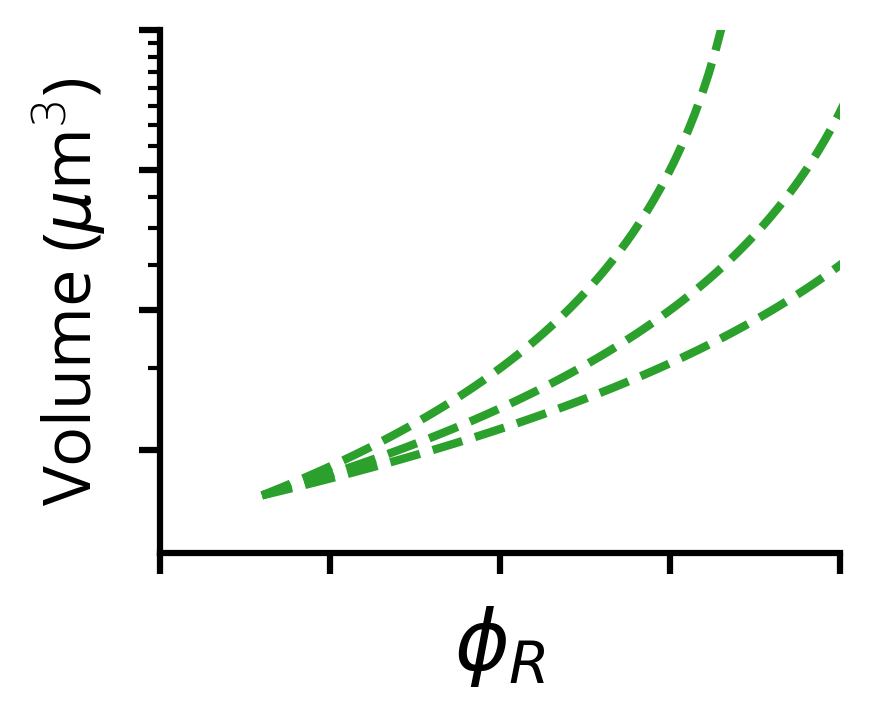

In [13]:
fig,ax = plt.subplots(1,1,figsize=(3,2.5))

schematic_idx = 0
schematic_delta_R_intercept_list = [0.4,0.4,0.4]
schematic_phi_Dmax_list = [0.4,0.5,0.3]
schematic_delta_phi_Dmax_list = [0.4,0.4,0.4]
schematic_delta_phi_Rmax_list = [0.8,0.8,0.8]

for schematic_idx in range(len(schematic_delta_R_intercept_list)):

    schematic_phi_D0_temp = schematic_phi_Dmax_list[schematic_idx]-schematic_delta_phi_Dmax_list[schematic_idx]
    schematic_R_intercept_temp = schematic_delta_R_intercept_list[schematic_idx] + schematic_phi_R0
    schematic_xi_temp = schematic_delta_phi_Dmax_list[schematic_idx]/schematic_delta_phi_Rmax_list[schematic_idx]
    
    schematic_delta_R_series_temp = np.linspace(0,schematic_delta_phi_Rmax_list[schematic_idx],num=100)
    schematic_R_series_temp = schematic_delta_R_series_temp + schematic_phi_R0
    
    schematic_volumes_temp = schematic_S0*((1 - schematic_xi_temp*(schematic_delta_R_series_temp/schematic_phi_Dmax_list[schematic_idx]))**-1)
    schematic_volume_intercept_temp = schematic_S0*((1 - schematic_xi_temp*(schematic_delta_R_intercept_list[schematic_idx]/schematic_phi_Dmax_list[schematic_idx]))**-1)

    positive_volumes_mask = schematic_volumes_temp>0
    schematic_volumes_temp = schematic_volumes_temp[positive_volumes_mask]
    schematic_R_series_temp = schematic_R_series_temp[positive_volumes_mask]
    
    
    plt.plot(schematic_R_series_temp,schematic_volumes_temp,linewidth=2,zorder=-15,color="tab:green",linestyle = "--")
# plt.scatter(schematic_R_intercept_temp,schematic_volume_intercept_temp,color="black",zorder=-11,s=70)
# plt.vlines([schematic_R_intercept],ax.get_ylim()[0],ax.get_ylim()[1],color="black",zorder=-11,linestyle="--",linewidth=1.5)
# ax.axvspan(0, schematic_R_intercept, color="tab:orange", linewidth=0,zorder=-16,alpha=0.3)
# ax.axvspan(schematic_R_intercept, ax.get_xlim()[1] , color="tab:purple", linewidth=0,zorder=-16,alpha=0.3)

plt.ylabel(r"Volume ($\mu$m$^{3}$)", fontsize=16)
plt.xlabel(r"$\phi_{R}$", fontsize=20)

ax.set_yscale("log",base=2)
ax.set_yscale("log", base=2)
ax.set_yticks(ticks=[2, 4, 8, 16], labels=["", "", "", ""], minor=False)
ax.set_yticks(ticks=[3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15], labels=[], minor=True)

ax.set_xticks(ticks=[0,0.2,0.4,0.6,0.8],labels=["","","","",""],minor=False)
# ax.set_xticks(ticks=[0.25,0.75],labels=[],minor=True)
plt.xlim(0, 0.8)
plt.ylim(0, 16)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1.5, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)
# Remove top and right spines
sns.despine(right=True, top=True)
sns.despine()

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_7/phiR_Length_Schematic_Simple.png",dpi=500,transparent=False,bbox_inches="tight")

## Figure 7B

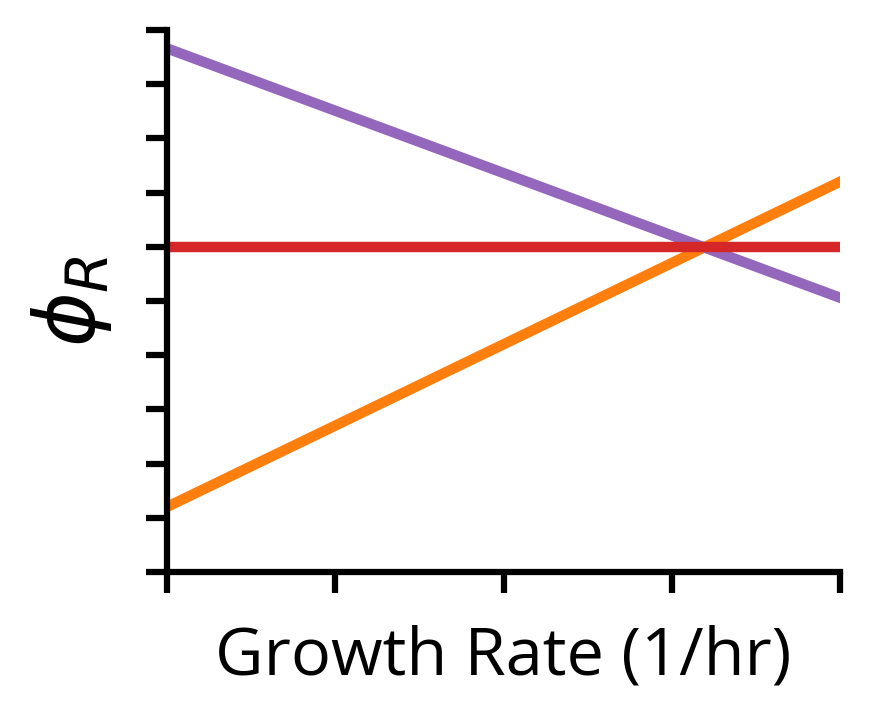

In [21]:
fig = plt.figure(figsize=(3,2.5))
ax = plt.subplot(1,1,1)

schematic_delta_R_series_tRNA = schematic_tRNA_beta*schematic_growth_series
schematic_delta_R_series_Elong = (schematic_phi_Rmax + schematic_Elong_beta*schematic_growth_series) - schematic_phi_R0

ax.plot(schematic_growth_series,schematic_phi_R0 + schematic_delta_R_series_tRNA,linewidth=2.5,zorder=-15,color="tab:orange")
ax.plot(schematic_growth_series,schematic_phi_R0 + schematic_delta_R_series_Elong,linewidth=2.5,zorder=-15,color="tab:purple")
ax.plot(schematic_growth_series,np.repeat(schematic_R_intercept,len(schematic_growth_series)),linewidth=2.5,zorder=-15,color="tab:red")

ax.set_ylabel(r"$\phi_{R}$", fontsize=20)
plt.xlabel(r"Growth Rate (1/hr)", fontsize=16)

ax.set_yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],labels=["","","","","","","","","","",""],minor=False)
ax.set_xticks(ticks=[0,0.5,1.,1.5,2],labels=["","","","",""],minor=False)
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1.5, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)

sns.despine(right=True, top=True)
sns.despine()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_7/Schematic_phiR.png",dpi=500,transparent=False)

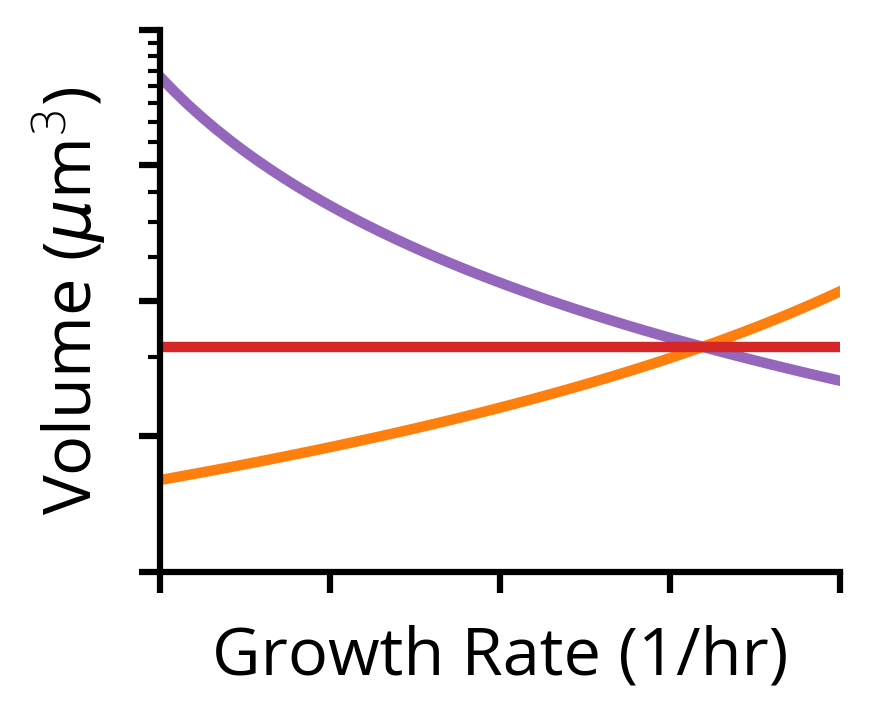

In [22]:
fig = plt.figure(figsize=(3,2.5))
ax = plt.subplot(1,1,1)

schematic_volumes_tRNA = schematic_S0*((1 - schematic_phi*(schematic_delta_R_series_tRNA/schematic_phi_Rmax))**-1)
schematic_volumes_Elong = schematic_S0*((1 - schematic_phi*(schematic_delta_R_series_Elong/schematic_phi_Rmax))**-1)

ax.plot(schematic_growth_series,schematic_volumes_tRNA,linewidth=2.5,zorder=-15,color="tab:orange")
ax.plot(schematic_growth_series,schematic_volumes_Elong,linewidth=2.5,zorder=-15,color="tab:purple")
ax.plot(schematic_growth_series,np.repeat(schematic_volume_intercept,len(schematic_growth_series)),linewidth=2.5,zorder=-15,color="tab:red")

plt.ylabel(r"Volume ($\mu$m$^{3}$)", fontsize=16)
plt.xlabel(r"Growth Rate (1/hr)", fontsize=16)
ax.set_yscale("log",base=2)

ax.set_yticks(ticks=[1,2,4,8,16],labels=["","","","",""],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13,14,15],labels=[],minor=True)
ax.set_xticks(ticks=[0,0.5,1.,1.5,2],labels=["","","","",""],minor=False)

# ax.set_yticks(ticks=[2,3,4,5,6], labels=["","","","",""], minor=False)
# ax.set_xticks(ticks=[0,0.5,1.,1.5,2],labels=["","","","",""],minor=False)
ax.set_xlim(0, 2)
ax.set_ylim(1, 16)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1.5, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)

sns.despine(right=True, top=True)
sns.despine()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_7/Schematic_Volume.png",dpi=500,transparent=False)

#### Individual Gene Fits

In [23]:
def fit_reg_genewise(df,Proteome_initial_guess=[0],Proteome_bounds=([-np.inf],[np.inf]),alpha_Proteome=1,S0_Proteome=2):
    #regress an SMK or Proteome Growth Model
    #output R2 of the fit as a measure of model quality
    
    growth_vals = df["Instantaneous Growth Rate: Volume"].values
    volume_vals = df["Volume"].values

    Proteome_popt, Proteome_pcov = curve_fit(partial(Proteome_scaling, S0=S0_Proteome, alpha=alpha_Proteome), growth_vals, volume_vals,\
                                             p0=Proteome_initial_guess, bounds=Proteome_bounds)

    # Extract the best-fit values
    Proteome_kappa_fit = Proteome_popt[0]
    Proteome_log_likelihood,Proteome_R2 = compute_log_likelihood_and_R2(growth_vals,volume_vals,partial(Proteome_scaling, S0=S0_Proteome,\
                                                                                                        alpha=alpha_Proteome),Proteome_kappa_fit)

    Proteome_BIC = 2*np.log(len(growth_vals)) - 2*Proteome_log_likelihood

    max_volume,min_volume = np.max(volume_vals),np.min(volume_vals)
    min_growth,volume_at_min_growth = np.min(growth_vals),volume_vals[np.argmin(growth_vals)]

    if "Ribo Type" in df.columns:
        output = pd.Series({"Proteome S0":S0_Proteome,"Proteome Kappa":Proteome_kappa_fit,"Proteome Eta/Alpha":alpha_Proteome,\
                            "Proteome R2":Proteome_R2, "Proteome BIC":Proteome_BIC,\
                           "Min Growth":min_growth, "Max Volume":max_volume, "Min Volume":min_volume,"Volume at Min Growth Rate":volume_at_min_growth,\
                           "Ribo Type":df["Ribo Type"].iloc[0]})
    else:
        output = pd.Series({"Proteome S0":S0_Proteome,"Proteome Kappa":Proteome_kappa_fit,"Proteome Eta/Alpha":alpha_Proteome,\
                            "Proteome R2":Proteome_R2, "Proteome BIC":Proteome_BIC,\
                           "Min Growth":min_growth, "Max Volume":max_volume, "Min Volume":min_volume,"Volume at Min Growth Rate":volume_at_min_growth})
        
    return output

def compute_log_likelihood_and_R2(growth_vals,volume_vals,model,*model_params):
    # Compute residuals
    residuals = volume_vals - model(growth_vals, *model_params)
    # Maximum-likelihood estimate of variance
    N = len(volume_vals)
    SSE = np.sum(residuals**2)         # Sum of squared errors
    var_hat = SSE / N  # MLE estimate for the variance 
    
    # 6. Compute the (Gaussian) log-likelihood (
    log_likelihood = (
        -0.5 * N * np.log(2 * np.pi)
        -0.5 * N * np.log(var_hat)
        -0.5 * (SSE / var_hat)
    )
    SST = np.sum((volume_vals-np.mean(volume_vals))**2)
    R2 = 1 - (SSE/SST)
    return log_likelihood,R2

## Figure 7C

In [24]:
## get WT growth rate from controls
wt_growth_rate = np.median(ss_estimators_df_controls_only["Instantaneous Growth Rate: Volume"])

## Normalizing FusA measurments to library
wt_volume = np.median(ss_estimators_df_controls_only["Volume"])

fusA_full_induction = all_fusA_isolate_df[all_fusA_isolate_df["Condition"] == "1uM AHL"]

growth_scaling_factor = wt_growth_rate/fusA_full_induction["Instantaneous Growth Rate: Volume"].iloc[0]
volume_scaling_factor = wt_volume/fusA_full_induction["Volume"].iloc[0]

all_fusA_isolate_df_scaled = all_fusA_isolate_df.copy()
all_fusA_isolate_df_scaled["Instantaneous Growth Rate: Volume"] = all_fusA_isolate_df_scaled["Instantaneous Growth Rate: Volume"]*growth_scaling_factor
all_fusA_isolate_df_scaled["Volume"] = all_fusA_isolate_df_scaled["Volume"]*volume_scaling_factor

fusA_pheT_df = pd.concat([all_fusA_isolate_df_scaled,pheT_df])

## testing drop
# pheT_df_baselined = pheT_df_baselined[pheT_df_baselined.index != 23954]

# # test 
# pheT_df_baselined = pheT_df_baselined[pheT_df_baselined["Instantaneous Growth Rate: Volume"]<1.3]

In [25]:
gene_dict = {gene_name:idx for idx,gene_name in enumerate(fusA_pheT_df["Gene"].unique())}
fusA_pheT_df["Gene Index"] = fusA_pheT_df["Gene"].apply(lambda x: gene_dict[x])

volume_vals = fusA_pheT_df["Volume"].values
growth_vals = fusA_pheT_df["Instantaneous Growth Rate: Volume"].values
growth_rates_forsigma = fusA_pheT_df["Instantaneous Growth Rate: Volume"].values.reshape(-1, 1)

S0_init = 1.6
S0_lower_bound = 0
S0_upper_bound = np.inf

kappa_tRNA_init = 0.3
kappa_tRNA_lower_bound = 0
kappa_tRNA_upper_bound = 1

kappa_elong_init = -0.2
kappa_elong_lower_bound = -1
kappa_elong_upper_bound = 0

# init_kappa_values = [0 for i in range(len(gene_dict))]
# kappa_lower_bounds = [-np.inf for i in range(len(gene_dict))]
# kappa_upper_bounds = [np.inf for i in range(len(gene_dict))]

Isolate_Proteome_initial_guess = [S0_init,kappa_tRNA_init,kappa_elong_init]
Isolate_Proteome_bounds = [(S0_lower_bound,kappa_tRNA_lower_bound,kappa_elong_lower_bound),\
                           (S0_upper_bound,kappa_tRNA_upper_bound,kappa_elong_upper_bound)]

Proteome_popt, Proteome_pcov = curve_fit(partial(Proteome_scaling_global_wrapper, wt_growth_rate=wt_growth_rate),\
                                         fusA_pheT_df, volume_vals, \
                                         p0=Isolate_Proteome_initial_guess, bounds=Isolate_Proteome_bounds)
Proteome_log_likelihood,Proteome_R2 = compute_log_likelihood_and_R2_Proteome(fusA_pheT_df,Proteome_scaling_global,*Proteome_popt,\
                                                                            wt_growth_rate=wt_growth_rate)

S0_Isolate_Proteome = Proteome_popt[0]
kappa_tRNA_Isolate_Proteome = Proteome_popt[1]
kappa_elong_Isolate_Proteome = Proteome_popt[2]
alpha_Isolate_Proteome = get_alpha(kappa_tRNA_Isolate_Proteome, kappa_elong_Isolate_Proteome, wt_growth_rate)

In [26]:
# pheT_df_baselined = fusA_pheT_df[fusA_pheT_df["Gene"]=="pheT"]
# all_fusA_isolate_df = fusA_pheT_df[fusA_pheT_df["Gene"]=="fusA"]

fusA_reg = fit_reg_genewise(all_fusA_isolate_df_scaled.drop(columns=['Ribo Type']),alpha_Proteome=alpha_Isolate_Proteome,S0_Proteome=S0_Isolate_Proteome).to_frame().T
fusA_reg["Gene"] = "fusA"
# fusA_reg = fusA_reg.set_index("Gene")

pheT_reg = fit_reg_genewise(pheT_df.drop(columns=['Ribo Type']),alpha_Proteome=1,S0_Proteome=S0_Isolate_Proteome).to_frame().T
pheT_reg["Gene"] = "pheT"
# pheT_reg = pheT_reg.set_index("Gene")

fusA_kappa = fusA_reg["Proteome Kappa"].iloc[0]
pheT_kappa = pheT_reg["Proteome Kappa"].iloc[0]

## from the intersection condition
Isolate_beta_tRNA_calibrated = ((phi_Rmax-phi_R0)/wt_growth_rate)*((1-(fusA_kappa/pheT_kappa))**-1)
Isolate_intersection_volume = S0_Isolate_Proteome*((1-pheT_kappa*wt_growth_rate)**-1)

fusA_reg["Predicted Beta"] = (fusA_kappa/pheT_kappa)*Isolate_beta_tRNA_calibrated
pheT_reg["Predicted Beta"] = Isolate_beta_tRNA_calibrated
# fusA_reg["Predicted Beta"] = delta_phi_R_baseline_to_max*(fusA_kappa/alpha_Isolate_Proteome)
# pheT_reg["Predicted Beta"] = delta_phi_R_baseline*(pheT_kappa/eta_Isolate_Proteome)

fusA_reg = fusA_reg.join(all_fusA_isolate_df_scaled.set_index("Gene"),on="Gene").dropna(subset=["Proteome Kappa"])
pheT_reg = pheT_reg.join(pheT_df.set_index("Gene"),on="Gene").dropna(subset=["Proteome Kappa"])

fusA_reg["Predicted R"] = phi_Rmax + fusA_reg["Predicted Beta"]*fusA_reg["Instantaneous Growth Rate: Volume"]
pheT_reg["Predicted R"] = (pheT_reg["Predicted Beta"]*pheT_reg["Instantaneous Growth Rate: Volume"]) + phi_R0

fusA_reg["Predicted RNA/Protein"] = fusA_reg["Predicted R"]/rho_conversion
pheT_reg["Predicted RNA/Protein"] = pheT_reg["Predicted R"]/rho_conversion

In [27]:
## tRNA only fits
growth_x,volume_y = pheT_df["Instantaneous Growth Rate: Volume"],pheT_df["Volume"]
S0_tRNA_proteome, kappa_tRNA_proteome = curve_fit(Proteome_scaling_tRNA, growth_x, volume_y, p0=(2,0.3), bounds=((0,0.),(np.inf,1)))[0]
S0_tRNA_SMK, kappa_tRNA_SMK = curve_fit(SMK_scaling_tRNA, growth_x, volume_y, p0=(2,0.3), bounds=((0,0.),(np.inf,np.inf)))[0]
S0_tRNA_linear, kappa_tRNA_linear = curve_fit(linear_scaling_tRNA, growth_x, volume_y, p0=(2,0.3), bounds=((0,0.),(np.inf,np.inf)))[0]

/tmp/ipykernel_503/2595984042.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 5)


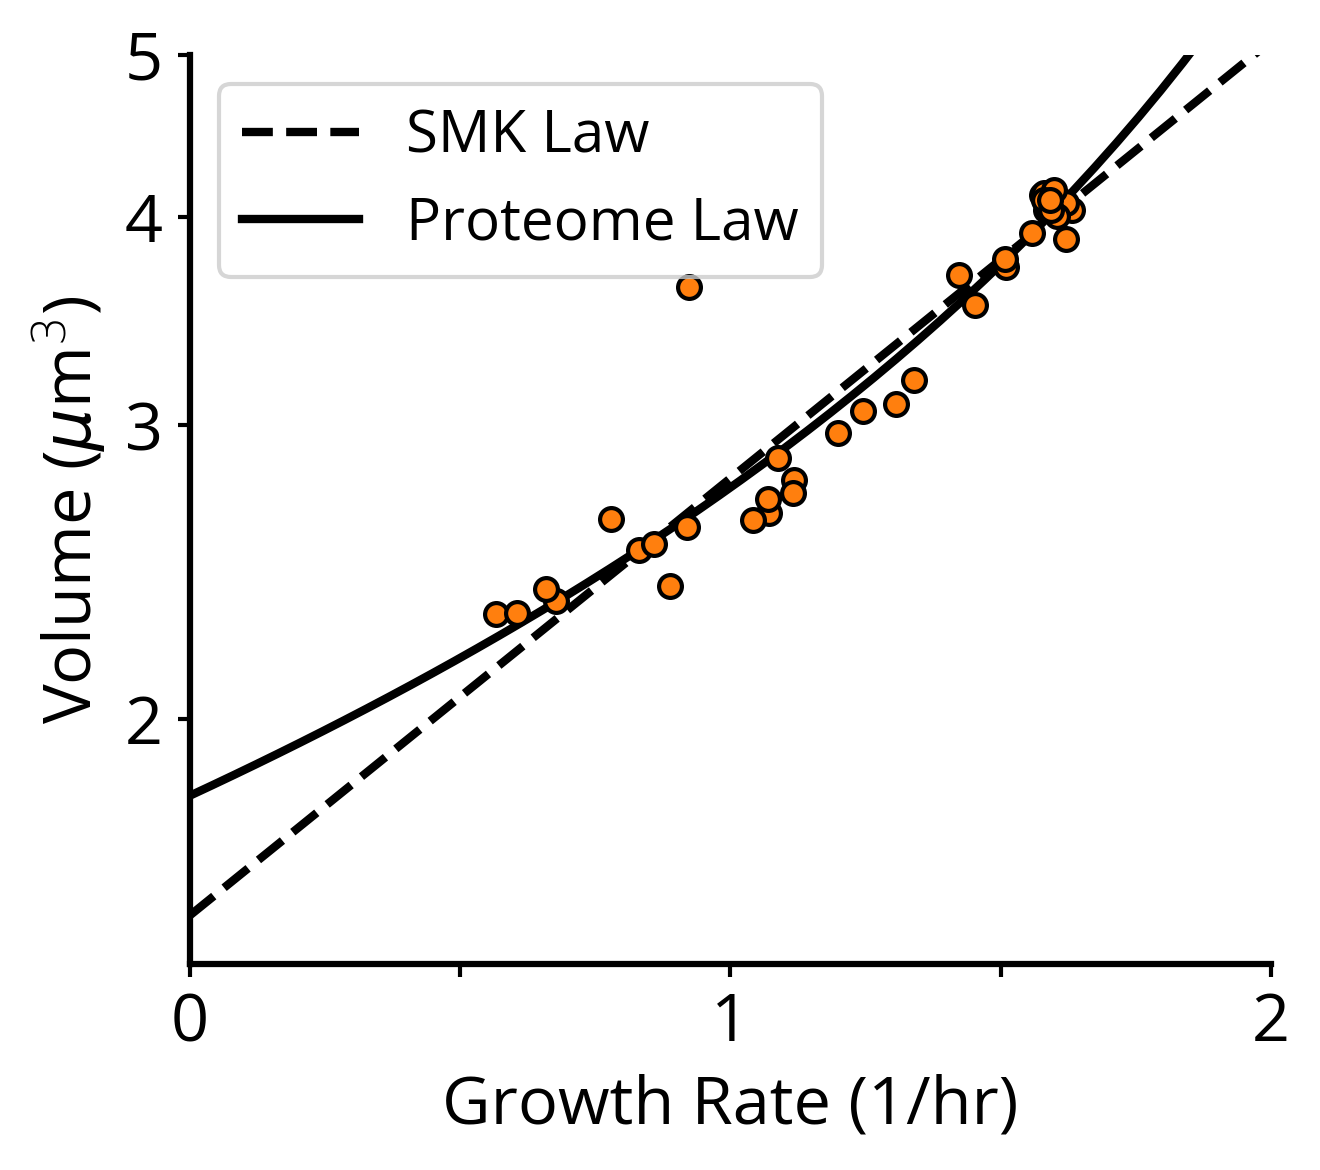

In [28]:
fig,ax = plt.subplots(1,1,figsize=(4.5,4))
# Set a light grey background

plt.plot(np.linspace(0, 2),SMK_scaling_tRNA(np.linspace(0, 2),S0_tRNA_SMK,kappa_tRNA_SMK),
         color="black",zorder=-15,linewidth=2,linestyle="--",label="SMK Law")

# plt.plot(np.linspace(0, 2),S0_Isolate_Proteome*np.exp(np.linspace(0, 2)*kappa_tRNA_Isolate_Proteome),
#          color="black",zorder=-15,linewidth=2,linestyle="--",label="SMK Law")

plt.scatter(pheT_df["Instantaneous Growth Rate: Volume"],pheT_df["Volume"],s=30,linewidth=1,edgecolor="black",color="tab:orange",zorder=-12)

plt.plot(np.linspace(0, 2),
         Proteome_scaling_tRNA(np.linspace(0, 2), S0_tRNA_proteome, kappa_tRNA_proteome),
         color="black",zorder=-15,linewidth=2,label="Proteome Law")

plt.xlabel("Growth Rate (1/hr)", fontsize=16)
plt.ylabel(r"Volume ($\mu$m$^{3}$)", fontsize=16)
ax.set_yscale("log", base=2)
ax.set_yticks(ticks=[2, 3, 4, 5], labels=["2","3","4","5"], minor=False)
ax.set_xticks(ticks=[0, 1, 2], minor=False)
# ax.set_yticks(ticks=[3, 5, 6, 7], labels=[], minor=True)
ax.set_xticks(ticks=[0.5, 1.5], labels=[], minor=True)
plt.xlim(0, 2)
plt.ylim(0, 5)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, length=3)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)

# Remove top and right spines
sns.despine(right=True, top=True)
sns.despine()

plt.legend(fontsize=14,loc="upper left")
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_7/Isolate_Length_Fit_tRNA.png",dpi=500,transparent=True,bbox_inches="tight")

In [29]:
# bootstraps
bootstrap_linspace = np.linspace(0,2)
bootstrap_R_linspace = np.linspace(0,1.2)
bootstrap_delta_R_linspace = bootstrap_R_linspace - phi_R0
n_bootstraps = 100

## get residuals
predicted_volumes = Proteome_scaling_global_wrapper(fusA_pheT_df,S0_Isolate_Proteome,kappa_tRNA_Isolate_Proteome,kappa_elong_Isolate_Proteome)
residuals = volume_vals - predicted_volumes

tRNA_prediction_boots = []
elong_prediction_boots = []

## beta bootstrap
Isolate_beta_tRNA_calibrated_boots = []
ribosome_volume_boots = []
Isolate_intersection_volume_boots = []

## kappa bootstrap
kappa_tRNA_Isolate_Proteome_boots = []
kappa_elong_Isolate_Proteome_boots = []

for i in range(n_bootstraps):
    fusA_pheT_df_bootstrap = fusA_pheT_df.copy(deep=True)
    
    sampled_residuals = np.random.choice(residuals,size=len(residuals))
    residual_bootstrap_volume = predicted_volumes + sampled_residuals
    fusA_pheT_df_bootstrap["Volume"] = residual_bootstrap_volume
    
    Proteome_popt_boot, Proteome_pcov_boot = curve_fit(partial(Proteome_scaling_global_wrapper,wt_growth_rate=wt_growth_rate),\
                                                       fusA_pheT_df_bootstrap, residual_bootstrap_volume, p0=Isolate_Proteome_initial_guess, bounds=Isolate_Proteome_bounds)
    
    S0_Isolate_Proteome_single_boot = Proteome_popt_boot[0]
    kappa_tRNA_Isolate_Proteome_boot = Proteome_popt_boot[1]
    kappa_elong_Isolate_Proteome_boot = Proteome_popt_boot[2]
    
    kappa_tRNA_Isolate_Proteome_boots.append(kappa_tRNA_Isolate_Proteome_boot)
    kappa_elong_Isolate_Proteome_boots.append(kappa_elong_Isolate_Proteome_boot)
    
    alpha_Isolate_Proteome_single_boot = get_alpha(kappa_tRNA_Isolate_Proteome_boot, kappa_elong_Isolate_Proteome_boot, wt_growth_rate)

    tRNA_prediction_boot = Proteome_scaling_tRNA(bootstrap_linspace,S0_Isolate_Proteome_single_boot,kappa_tRNA_Isolate_Proteome_boot)
    elong_prediction_boot = Proteome_scaling(bootstrap_linspace,kappa_elong_Isolate_Proteome_boot,S0 = S0_Isolate_Proteome_single_boot, alpha = alpha_Isolate_Proteome_single_boot)

    tRNA_prediction_boots.append(tRNA_prediction_boot)
    elong_prediction_boots.append(elong_prediction_boot)
    
    ## bootstrapping beta and ribosome-volume uncertainty
    phi_Rmax_sample = np.random.normal(phi_Rmax, phi_Rmax_sem)
    phi_R0_sample = np.random.normal(phi_R0, phi_R0_sem)
    ## intersection based
    Isolate_beta_tRNA_calibrated_boot = ((phi_Rmax_sample-phi_R0_sample)/wt_growth_rate)*((1-(kappa_elong_Isolate_Proteome_boot/kappa_tRNA_Isolate_Proteome_boot))**-1)
    ribosome_volume_boot = S0_Isolate_Proteome_single_boot*((1 - (kappa_tRNA_Isolate_Proteome_boot/Isolate_beta_tRNA_calibrated_boot)*bootstrap_delta_R_linspace)**-1)
    Isolate_intersection_volume_boot = S0_Isolate_Proteome_single_boot*((1-kappa_tRNA_Isolate_Proteome_boot*wt_growth_rate)**-1)

    Isolate_beta_tRNA_calibrated_boots.append(Isolate_beta_tRNA_calibrated_boot)
    ribosome_volume_boots.append(ribosome_volume_boot)
    Isolate_intersection_volume_boots.append(Isolate_intersection_volume_boot)
    

tRNA_prediction_boots = np.array(tRNA_prediction_boots)
elong_prediction_boots = np.array(elong_prediction_boots)
Isolate_beta_tRNA_calibrated_boots = np.array(Isolate_beta_tRNA_calibrated_boots)
ribosome_volume_boots = np.array(ribosome_volume_boots)
Isolate_intersection_volume_boots = np.array(Isolate_intersection_volume_boots)

kappa_tRNA_Isolate_Proteome_boots = np.array(kappa_tRNA_Isolate_Proteome_boots)
kappa_elong_Isolate_Proteome_boots = np.array(kappa_elong_Isolate_Proteome_boots)

In [30]:
## computing bounds
percentile_lower,percentile_upper = 2.5,97.5

tRNA_lower_bound,tRNA_upper_bound = np.percentile(tRNA_prediction_boots,percentile_lower,axis=0),np.percentile(tRNA_prediction_boots,percentile_upper,axis=0)
elong_lower_bound,elong_upper_bound = np.percentile(elong_prediction_boots,percentile_lower,axis=0),np.percentile(elong_prediction_boots,percentile_upper,axis=0)
intersection_volume_lower_bound,intersection_volume_upper_bound = np.percentile(Isolate_intersection_volume_boots,percentile_lower,axis=0),\
                                                                    np.percentile(Isolate_intersection_volume_boots,percentile_upper,axis=0)

kappa_tRNA_sem, kappa_elong_sem = np.std(kappa_tRNA_Isolate_Proteome_boots),np.std(kappa_elong_Isolate_Proteome_boots)

## replacing negative values with inf for asymptotic bebavior
ribosome_volume_boots[ribosome_volume_boots<0] = 10000000000
ribosome_lower_bound,ribosome_upper_bound = np.percentile(ribosome_volume_boots,percentile_lower,axis=0),np.percentile(ribosome_volume_boots,percentile_upper,axis=0)

## Figure 7D

/tmp/ipykernel_503/2464199349.py:75: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 14)


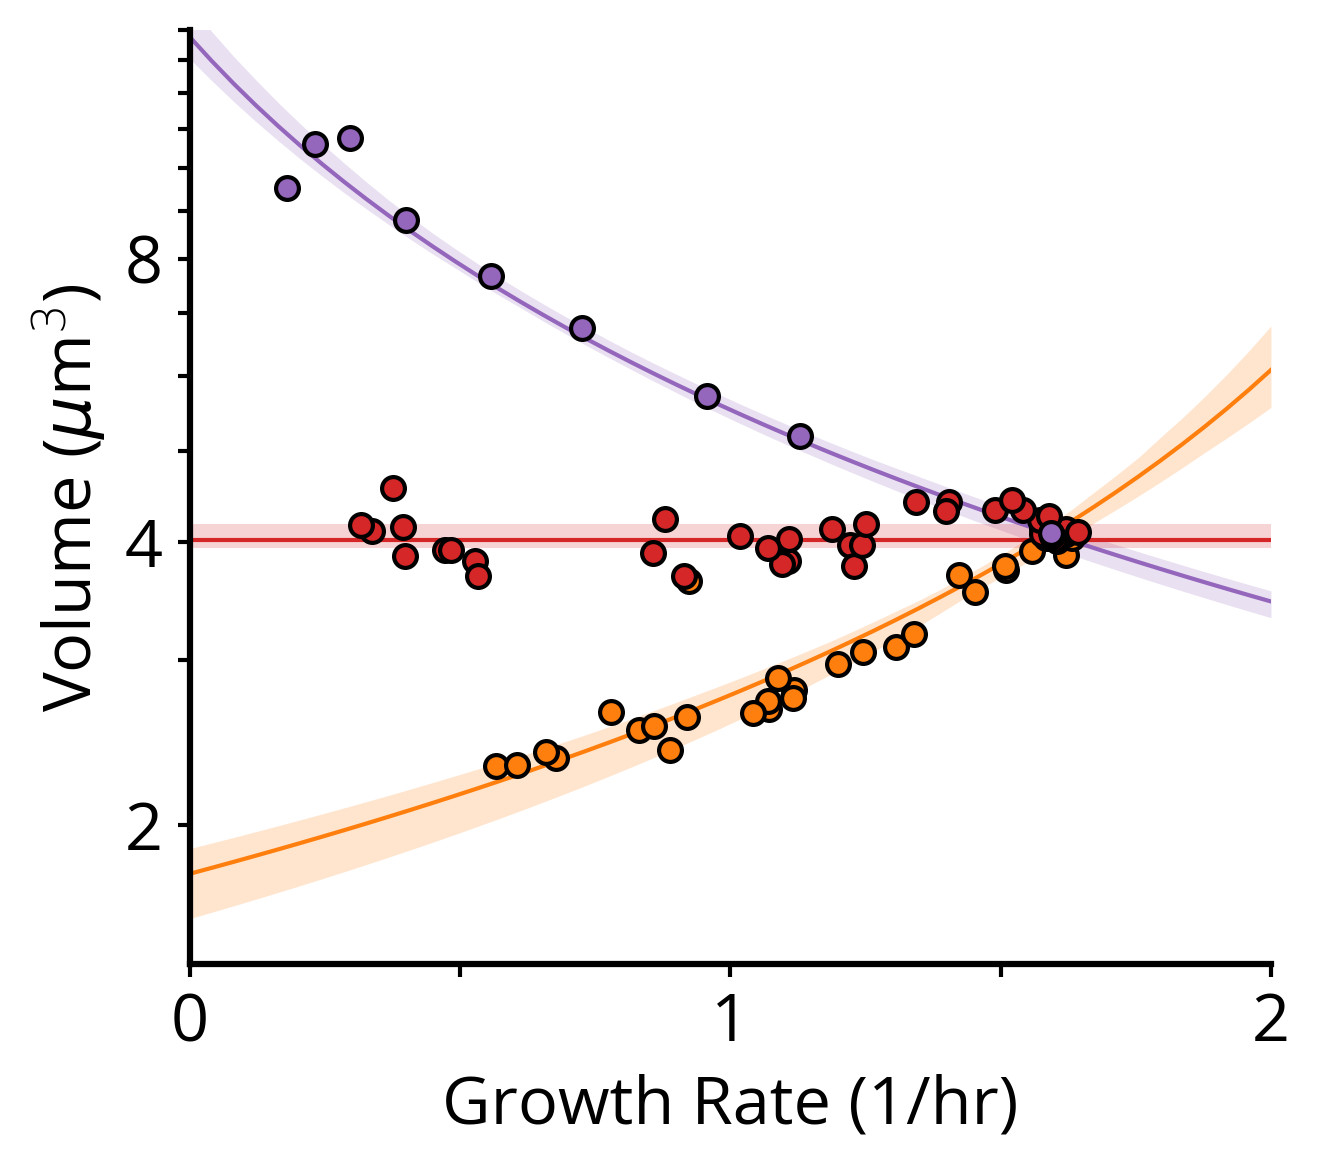

In [31]:
fig,ax = plt.subplots(1,1,figsize=(4.5,4))
# Set a light grey background

plt.scatter(all_fusA_isolate_df_scaled["Instantaneous Growth Rate: Volume"],all_fusA_isolate_df_scaled["Volume"],s=30,linewidth=1,edgecolor="black",color="tab:purple",zorder=-11)

plt.plot(np.linspace(0, 2),
         Proteome_scaling(np.linspace(0, 2), kappa_elong_Isolate_Proteome, S0=S0_Isolate_Proteome, alpha=alpha_Isolate_Proteome),
         color="tab:purple",zorder=-15,linewidth=1)

plt.scatter(pheT_df["Instantaneous Growth Rate: Volume"],pheT_df["Volume"],s=30,linewidth=1,edgecolor="black",color="tab:orange",zorder=-12)

plt.plot(np.linspace(0, 2),
         Proteome_scaling(np.linspace(0, 2), kappa_tRNA_Isolate_Proteome, S0=S0_Isolate_Proteome, alpha=1),
         color="tab:orange",zorder=-15,linewidth=1)

plt.scatter(infA_df["Instantaneous Growth Rate: Volume"],infA_df["Volume"],s=30,linewidth=1,edgecolor="black",color="tab:red",zorder=-12)

plt.plot(np.linspace(0, 2),
         np.repeat(Isolate_intersection_volume,len(np.linspace(0, 2))),
         color="tab:red",zorder=-15,linewidth=1)

plt.fill_between(
    bootstrap_linspace,  # assuming R_linspace_scaled_upper == R_linspace_scaled_lower
    elong_upper_bound,
    elong_lower_bound,
    color='tab:purple',
    alpha=0.2,
    label='Confidence Interval',
    zorder=-20,
    linewidth=0
)

plt.fill_between(
    bootstrap_linspace,  # assuming R_linspace_scaled_upper == R_linspace_scaled_lower
    tRNA_upper_bound,
    tRNA_lower_bound,
    color='tab:orange',
    alpha=0.2,
    label='Confidence Interval',
    zorder=-20,
    linewidth=0
)

plt.fill_between(
    bootstrap_linspace,  # assuming R_linspace_scaled_upper == R_linspace_scaled_lower
    np.repeat(intersection_volume_upper_bound,len(bootstrap_linspace)),
    np.repeat(intersection_volume_lower_bound,len(bootstrap_linspace)),
    color='tab:red',
    alpha=0.2,
    label='Confidence Interval',
    zorder=-20,
    linewidth=0
)

# plt.fill_between(
#     np.linspace(0, 2),  # assuming R_linspace_scaled_upper == R_linspace_scaled_lower
#     Proteome_scaling(np.linspace(0, 2), kappa_elong_Isolate_Proteome + fusA_kappa_std_deviation*2, S0=S0_Isolate_Proteome, alpha=alpha_Isolate_Proteome),
#     Proteome_scaling(np.linspace(0, 2), kappa_elong_Isolate_Proteome - fusA_kappa_std_deviation*2, S0=S0_Isolate_Proteome, alpha=alpha_Isolate_Proteome),
#     color='gray',
#     alpha=0.4,
#     label='Confidence Interval',
#     zorder=-20,
#     linewidth=0
# )


plt.xlabel("Growth Rate (1/hr)", fontsize=16)
plt.ylabel(r"Volume ($\mu$m$^{3}$)", fontsize=16)
ax.set_yscale("log", base=2)
ax.set_yticks(ticks=[2, 4, 8, 16], labels=["2", "4", "8", "16"], minor=False)
ax.set_xticks(ticks=[0, 1, 2], minor=False)
ax.set_yticks(ticks=[3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15], labels=[], minor=True)
ax.set_xticks(ticks=[0.5, 1.5], labels=[], minor=True)
plt.xlim(0, 2)
plt.ylim(0, 14)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, length=3)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)

# Remove top and right spines
sns.despine(right=True, top=True)
sns.despine()

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_7/Isolate_Volume_Fit.png",dpi=500,transparent=True,bbox_inches="tight")

## Figure 7E

In [32]:
## fitted baseline growth rate from above
# baseline_growth_rate = delta_phi_R_baseline/pheT_reg["Predicted Beta"].iloc[0]

## below here is all RNA/Protein data
growth_linspace = np.linspace(0,2)

## setting phi_max
phi_max = phi_Rmax-phi_R0
delta_R_tRNA_linspace = tRNA_beta*growth_linspace
delta_R_elong_linspace = phi_max + ribo_beta*growth_linspace

## Mori Data (Higher Quality)

- Replace phiR baseline test
- Figure out the compression
- First Implement a "Generic" sector prediction
- Then plot the specific assignment case

In [33]:
# his_operon = ["hisG","hisD","hisC","hisB","hisH","hisA","hisF","hisI"]
# nonrsector = ["A","S","U","C"]

# ## loading mori data
# mori_ref_gr = 1

# mori_data = pd.read_csv("./2021_Mori_Data.csv")
# mori_data["Ref Mean"] = mori_data[["Ref Replicate 1","Ref Replicate 2","Ref Replicate 3"]].mean(axis=1)
# mori_data = mori_data[mori_data["Ref Mean"]>0]

# ## filtering our unassigned proteins
# mori_data = mori_data[mori_data["Protein sector"]!="X"]

# ## relabeling sectors
# mori_data["Protein sector"] = mori_data["Protein sector"].apply(lambda x: "NP" if x in nonrsector else "P")

# ## Relabel based on true ribosome sector
# mori_data["Ribosome"] = (mori_data["Gene name"].isin(ribo))&(mori_data["Protein sector"] == "P")
# mori_data.loc[(mori_data["Protein sector"] == "P")&(mori_data["Ribosome"]),"Protein sector"] = "R"

# ## relabel his
# mori_data.loc[mori_data["Gene name"].isin(his_operon),"Protein sector"] = "H"

# # ## testing ppGpp
# # mori_data.loc[mori_data["Gene name"].isin(sv_data_increased_list),"Protein sector"] = "H"

# # ## getting slopes in mass fraction units
# mori_data["Real R-lim Slope"] = mori_data["Slope R-lim"]*mori_data["Ref Mean"]
# mori_data["Real C-lim Slope"] = mori_data["Slope C-lim"]*mori_data["Ref Mean"]
# mori_data["Real A-lim Slope"] = mori_data["Slope A-lim"]*mori_data["Ref Mean"]

# ## averaging slopes, means by sector
# sector_rlim_slopes = mori_data.groupby("Protein sector")["Real R-lim Slope"].sum()
# sector_clim_slopes = mori_data.groupby("Protein sector")["Real C-lim Slope"].sum()
# sector_alim_slopes = mori_data.groupby("Protein sector")["Real A-lim Slope"].sum()
# sector_ref_frac = mori_data.groupby("Protein sector")["Ref Mean"].sum()

# ## computing intercepts
# sector_rlim_intercepts = sector_ref_frac - (sector_rlim_slopes*mori_ref_gr)
# sector_clim_intercepts = sector_ref_frac - (sector_clim_slopes*mori_ref_gr)
# sector_alim_intercepts = sector_ref_frac - (sector_alim_slopes*mori_ref_gr)

# ## new approach
# sector_betas = sector_rlim_slopes/sector_rlim_slopes["R"]
# mori_Rmax = sector_rlim_intercepts["R"]
# mori_Rref = sector_ref_frac["R"]
# mori_R0 = sector_clim_intercepts["R"]
# mori_delta_Rref = mori_Rref-mori_R0

# sector_phi0 = sector_ref_frac - sector_betas*mori_delta_Rref

# ## testing mori conversion factor 
# # mori_rho_conversion_max = (mori_Rmax/phi_Rmax)*rho_conversion
# # mori_rho_conversion_min = (mori_R0/phi_R0)*rho_conversion
# # mori_rho_conversion = (mori_rho_conversion_max + mori_rho_conversion_min)/2

# mori_rho_conversion = (mori_Rmax/phi_Rmax)*rho_conversion

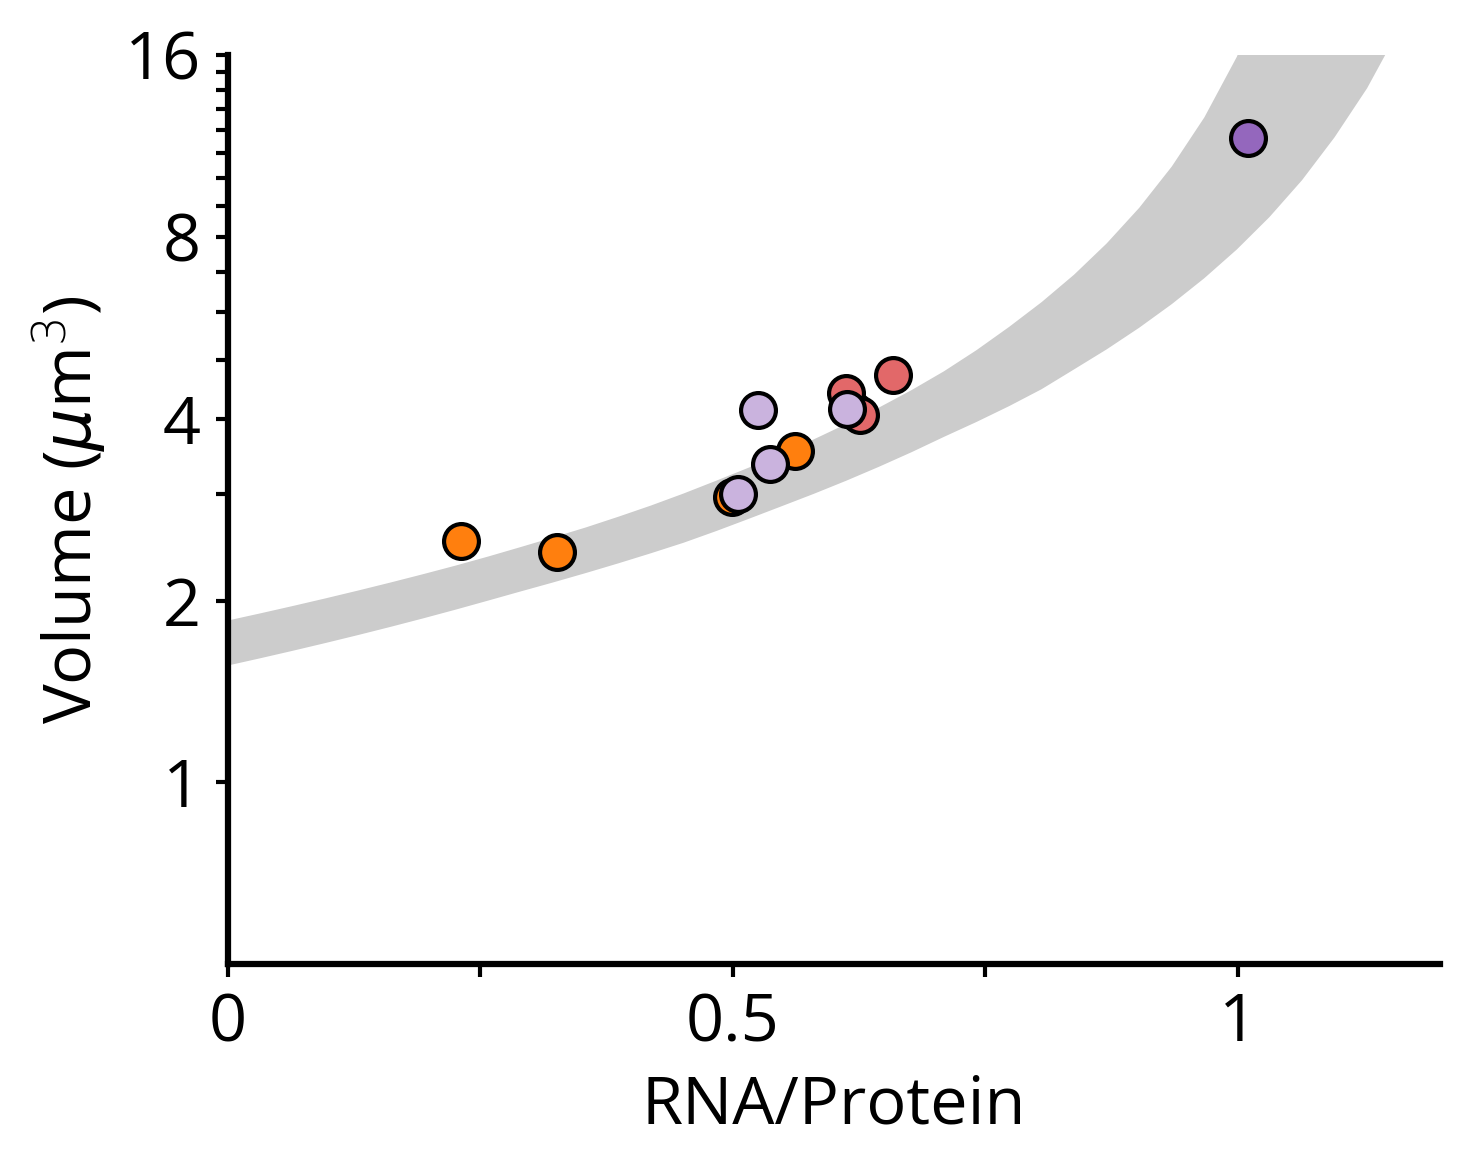

In [36]:
# R_linspace = np.linspace(0,0.7)
# mori_delta_R_linspace = mori_R_linspace - mori_R0

fig,ax = plt.subplots(1,1,figsize=(5,4))

# ##sector lineas
# sector_list = ["P","NP","H"]
# sector_colors = ["tab:purple","tab:green","tab:olive"]
# for sector_idx,sector in enumerate(sector_list):
#     sector_color = sector_colors[sector_idx]
#     pred_sector = sector_phi0[sector] + mori_delta_R_linspace*sector_betas[sector]
#     pred_vol = S0_Isolate_Proteome * (sector_phi0[sector]/pred_sector)
#     pred_vol_mask = pred_vol>0
#     pred_vol = pred_vol[pred_vol_mask]
#     mori_R_linspace_masked = mori_R_linspace[pred_vol_mask]
#     plt.plot(mori_R_linspace_masked/mori_rho_conversion,pred_vol,label=sector + " Sector",zorder=-20,linewidth=3,color=sector_color)

##model fit area
plt.fill_between(
    bootstrap_R_linspace/rho_conversion,  # assuming R_linspace_scaled_upper == R_linspace_scaled_lower
    ribosome_upper_bound,
    ribosome_lower_bound,
    color='gray',
    alpha=0.4,
    label='Confidence Interval',
    zorder=-20,
    linewidth=0
)

##points block

ax.scatter(RNA_Prot_data_mean.loc[("infA",20899)]["RNA/Protein"],\
           infA_growth_volume_df["Volume"], s=70,\
           color=list(infA_growth_volume_df["Color"].iloc[0]), edgecolors="black",\
           linewidth=1, zorder=-8)

ax.scatter(RNA_Prot_data_mean.loc["infA"].loc[infA_df_subset.index.tolist()]["RNA/Protein"],\
           infA_df_subset["Volume"], s=70,\
           color=list(infA_growth_volume_df["Color"].iloc[0]), edgecolors="black",\
           linewidth=1, zorder=-8)

ax.scatter(RNA_Prot_data_mean.loc[("pheT",23961)]["RNA/Protein"],\
           pheT_growth_volume_df["Volume"], s=70,\
           color=pheT_growth_volume_df["Color"].iloc[0], edgecolors="black",\
           linewidth=1, zorder=-8)

ax.scatter(RNA_Prot_data_mean.loc["pheT"].loc[pheT_df_subset.index.tolist()]["RNA/Protein"],\
           pheT_df_subset["Volume"], s=70,\
           color=pheT_growth_volume_df["Color"].iloc[0], edgecolors="black",\
           linewidth=1, zorder=-8)

ax.scatter(RNA_Prot_data_mean.loc[("rplL",702)]["RNA/Protein"],\
           rplL_growth_volume_df["Volume"], s=70,\
           color=rplL_growth_volume_df["Color"].iloc[0], edgecolors="black",\
           linewidth=1, zorder=-8)

ax.scatter(RNA_Prot_data_mean.loc["rplL"].loc[rplL_df_subset.index.tolist()]["RNA/Protein"],\
           rplL_df_subset["Volume"], s=70,\
           color=rplL_growth_volume_df["Color"].iloc[0], edgecolors="black",\
           linewidth=1, zorder=-8)

ax.scatter(RNA_Prot_data_mean.loc[(r"$p_{AHL}$-fusA",0)]["RNA/Protein"],\
           uninduced_fusA_isolate_df["Volume"], s=70,\
           color=uninduced_fusA_isolate_df["Color"].iloc[0], edgecolors="black",\
           linewidth=1, zorder=-8)

##aesthetics

plt.ylabel(r"Volume ($\mu$m$^{3}$)", fontsize=16)
plt.xlabel(r"RNA/Protein", fontsize=16)

ax.set_yscale("log",base=2)
ax.set_yscale("log", base=2)
ax.set_yticks(ticks=[1, 2, 4, 8, 16], labels=["1", "2", "4", "8", "16"], minor=False)
ax.set_yticks(ticks=[3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15], labels=[], minor=True)

ax.set_xticks(ticks=[0,0.5,1],labels=["0","0.5","1"],minor=False)
ax.set_xticks(ticks=[0.25,0.75],labels=[],minor=True)
plt.xlim(0, 1.2)
plt.ylim(0.5,16)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, length=3)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)
# Remove top and right spines
sns.despine(right=True, top=True)
sns.despine()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_7/Proteome_to_SizeRNA_Prediction.png",dpi=500,transparent=True,bbox_inches="tight")